In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from libpysal.weights import fuzzy_contiguity
import json
import dask
from dask import delayed, dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from dask.graph_manipulation import bind
import bokeh
import dask_geopandas as dgpd
import glob
from tqdm.dask import TqdmCallback

/tmp/ipykernel_391/2797345437.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# %%time
# for ch in range(10):
#     tess = gpd.read_parquet(f'./out/singapore/tess_chunk_{int(ch)}.pq')
#     tess = tess.reset_index(drop=True)
#     filler = pd.Series(range(len(tess[tess.uID.isna()])), index=tess[tess.uID.isna()].index) + ch * 100_000_000
#     tess['uID'] = tess.uID.fillna(filler)
#     tess.to_parquet(f'./out/singapore/tess_chunk_{int(ch)}.pq')

In [3]:
with open('./out/singapore/clustertess.json', 'r') as f:
    includes_dict = json.load(f)

In [4]:
chunks = gpd.read_parquet('./out/singapore/clusters.pq')

In [5]:
w = fuzzy_contiguity(chunks, buffering=True, buffer=1000)

<Axes: >

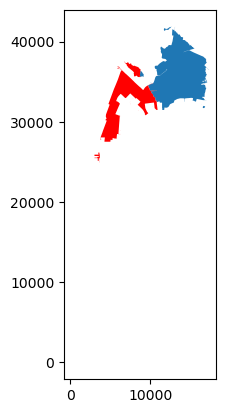

In [6]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

In [7]:
cluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='30GB')

client = Client(cluster)
client

2023-03-19 23:33:08,049 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,052 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,055 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,057 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,059 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,061 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,063 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-19 23:33:08,

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 124.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38775,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 124.66 GiB
Comm: tcp://127.0.0.1:37477,Total threads: 2
Dashboard: http://127.0.0.1:44469/status,Memory: 15.58 GiB
Nanny: tcp://127.0.0.1:43259,


In [9]:
%%time

queen_out = {}

def neigh_look(cell, main_chunk_ids, order, combined_chunks):
    neighbours = combined_chunks[~combined_chunks.geometry.disjoint(cell.geometry)]
    
    for index, neighbour in neighbours.iterrows():
        
        if not neighbour["uID"] in main_chunk_ids:
            main_chunk_ids.add(neighbour["uID"])

        if order < 3:
            main_chunk_ids.union(neigh_look(neighbour, main_chunk_ids, order+1, combined_chunks))
    
    return main_chunk_ids

@delayed
def process_chunk(n1, w, combined_chunks):
    main_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n1)}.pq")
    combined_chunks = main_chunk

    main_chunk_ids = set(main_chunk['uID'])
    queen_cells = main_chunk_ids

    for n2 in w.neighbors[n1]:
        neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n2)}.pq")
        combined_chunks = combined_chunks.append(neigh_chunk)

    i = 1
    total = len(main_chunk)

    for index, row in main_chunk.iterrows():
        queen_area = neigh_look(row, main_chunk_ids, 0, combined_chunks)

        print("n"+str(n1)+":"+str(i)+"/"+str(total))
        i = i+1

    return queen_area

# for n1 in tqdm(range(10), total=10):
#     queen_out[n1] = process_chunk(n1)

file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)
num_files = len(file_list)

combined_chunks=[]
delayed_tasks = []
for n1 in range(num_files):
    delayed_task = process_chunk(n1, w, combined_chunks)
    delayed_tasks.append(delayed_task)
with ProgressBar():
    results = dask.compute(*delayed_tasks)
for n1, queen_areas in enumerate(results):
    queen_out[n1] = set.union(*queen_areas)


751
4906
297
23
453
4907
752
n6:1/6039
38
1945
n8:1/7076
484
298
4908
n9:1/7573
3855
753
454
n8:2/7076
4909
302
754
4910
3856


KeyboardInterrupt: 

158
n8:3/7076
n9:2/7573
455
93
n5:1/15505
485
4911
755


In [ ]:
# %%time

# queen_out = {}

# @dask.delayed
# def find_neighbours(cell):
#     return combined_chunks[~combined_chunks.geometry.disjoint(cell.geometry)]

# @dask.delayed
# def neigh_look(uID, main_chunk_ids, order):

#     row = combined_chunks.loc[combined_chunks['uID'] == uID]
#     matching_row = row.iloc[0]

#     neighbours = find_neighbours(matching_row)
    
#     out_chunks_ids = main_chunk_ids

#     for neighbour_uID in neighbours["uID"]:
#         out_chunks_ids.union({neighbour_uID})

#         if order < 3:
#            out_chunks_ids.union(neigh_look(neighbour_uID, main_chunk_ids, order+1))

#     return out_chunks_ids

# @dask.delayed
# def setUnion (main_chunk_ids, queen_area_delayed):
#     return main_chunk_ids | set.union(*queen_area_delayed)


# for n1 in tqdm(range(1), total=1):
#     main_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n1)}.pq")
#     combined_chunks = main_chunk

#     main_chunk_ids = set(main_chunk['uID'])
#     queen_cells = main_chunk_ids

#     for n2 in w.neighbors[n1]:
#         neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n2)}.pq")
#         combined_chunks = combined_chunks.append(neigh_chunk)

#     dissolved_main_chunk = main_chunk.dissolve()

#     boundaries = dissolved_main_chunk.boundary

#     boundaries.plot()
    
    # queen_area_delayed = [] # list of uIDs to output
    # for row_uID in main_chunk_ids:
    #     # row_out = delayed(neigh_look)(row_uID, main_chunk_ids, 0, combined_chunks)
    #     row_out = client.submit(neigh_look, row_uID, main_chunk_ids, 0)

    #     queen_area_delayed.append(row_out)

    # queen_areas = dask.compute(*queen_area_delayed)
    # queen_set = setUnion(main_chunk_ids, queen_areas)

    # queen_out[n1] = queen_set

In [14]:
client.close()
There is no client function specifically for this.

The scheduler has a close() method which you could call using run_on_scheduler thus

c.run_on_scheduler(lambda dask_scheduler=None: 
    dask_scheduler.close() & sys.exit(0))
which will tell workers to disconnect and shutdown, and will close all connections before terminating the process. Note that this raises an error in the client, since the connection is broken without a reply. There are probably more elegant ways.

Note that the right way to do this is probably to interact with one of the deployment cluster managers. For example, LocalCluster has a user-facing close() method that you can call directly.

--EDIT--

client.shutdown()

n8:8/7076
760
n9:5/7573
4918
585
3861
n8:9/7076
463
487
55
27
761
4919
n6:5/6039
n8:10/7076
464
3862
762
586
4920
n5:3/15505
587
763
n9:6/7573
4921
n6:6/6039
3863
n8:11/7076
465
56
4922
n8:12/7076
3864
466
n6:7/6039
764
488
n5:4/15505
4923
588
467
127
n8:13/7076
4924
28
n6:8/6039
589
4925
765
57
3865
160
n9:7/7573
n8:14/7076
468
4926
n5:5/15505
4927
